# Tutorial #8: Monte Carlo Predictive Coding

In this notebook we will see how to create and train a simple MCPC model to learn a Gaussian data distribution.

In [42]:
from typing import Callable

# get evaluation and dataset
import random
import tempfile, shutil, os, subprocess, warnings
import numpy as np
from tqdm import tqdm

import torch
from pytorch_fid.fid_score_mnist import fid_mnist
from torchvision.utils import save_image
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from pytorch_fid.fid_score_mnist import save_stats_mnist
from inception_score import get_mnist_inception_score

# These are the default import names used in tutorials and documentation.
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import equinox as eqx
from optax._src import base 
from optax._src import combine
from optax._src import transform
from typing import Any, Callable, Optional, Union
import ot

import pcax as px
import pcax.predictive_coding as pxc
import pcax.nn as pxnn
import pcax.functional as pxf
import pcax.utils as pxu

px.RKG.seed(0)

In [43]:
class Model(pxc.EnergyModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        nm_layers: int,
        act_fn: Callable[[jax.Array], jax.Array],
        input_var = 1.0
    ) -> None:
        super().__init__()

        def se_energy_input(vode, rkg: px.RandomKeyGenerator = px.RKG):
            """Squared error energy function derived from a Gaussian distribution."""
            e = vode.get("h") - vode.get("u")
            return 0.5 * (e * e)/input_var


        self.act_fn = px.static(act_fn)
        
        self.layers = [pxnn.Linear(input_dim, hidden_dim)] + [
            pxnn.Linear(hidden_dim, hidden_dim) for _ in range(nm_layers - 2)
        ] + [pxnn.Linear(hidden_dim, output_dim)]

        self.vodes = [
            pxc.Vode((hidden_dim,)) for _ in range(nm_layers-1)
        ] + [pxc.Vode((output_dim,), se_energy_input)]
        
        self.out_vode_act_fn = px.static(jax.nn.tanh)
        
        self.vodes[-1].h.frozen = True

    def __call__(self, x, y):
        for v, l in zip(self.vodes[:-1], self.layers[:-1]):
            x = v(l(self.act_fn(x)))

        x = self.vodes[-1](self.out_vode_act_fn(self.layers[-1](self.act_fn(x))))

        if y is not None:
            self.vodes[-1].set("h", y)
        return self.vodes[-1].get("u")

In [44]:
@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0, 0), out_axes=0)
def forward(x, y, *, model: Model):
    return model(x, y)

@pxf.vmap(pxu.Mask(pxc.VodeParam | pxc.VodeParam.Cache, (None, 0)), in_axes=(0,), out_axes=(None, 0), axis_name="batch")
def energy(x, *, model: Model):
    y_ = model(x, None)
    return jax.lax.psum(model.energy().sum(), "batch"), y_

In [45]:
@pxf.jit(static_argnums=0)
def train_on_batch(
    T: int,
    x: jax.Array,
    y: jax.Array,
    *,
    model: Model,
    optim_w: pxu.Optim,
    optim_h: pxu.Optim
):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Training!")
    model.train()
    
    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, y, model=model)
    
    # Inference steps
    pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)

    # Learning step
    with pxu.step(model, clear_params=pxc.VodeParam.Cache):
        (e, y_), g = pxf.value_and_grad(pxu.Mask(pxnn.LayerParam, [False, True]), has_aux=True)(energy)(x, model=model)
    optim_w.step(model, g["model"])


def train(dl, T, *, model: Model, optim_w: pxu.Optim, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = True
    for x, y in tqdm(dl):
        train_on_batch(T, x, y, model=model, optim_w=optim_w, optim_h=optim_h)

In [46]:
@pxf.jit(static_argnums=0)
def eval_on_batch(
    T: int,
    x: jax.Array, 
    *, 
    model: Model,
    optim_h: pxu.Optim
    ):
    def h_step(i, x, *, model, optim_h):
        with pxu.step(model, clear_params=pxc.VodeParam.Cache):
            (e, y_), g = pxf.value_and_grad(
                pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True), [False, True]),
                has_aux=True
            )(energy)(x, model=model)
        optim_h.step(model, g["model"])
        return x, None

    print("Evaluation!")  
    model.train()

    if model.vodes[-1].h.frozen:
        print("vode[-1] should not be frozen! set frozen=False before calling eval function.")

    # Init step
    with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
        forward(x, None, model=model)
    
    # Inference steps
    x = pxf.scan(h_step, xs=jax.numpy.arange(T))(x, model=model, optim_h=optim_h)


def gen_imgs(dl, T, *, model: Model, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = False
    ys_ = []
    es = []
    for x, y in dl:
        eval_on_batch(T, x, model=model, optim_h=optim_h)
        u = forward(x, None, model=model)
        e = model.energy()
        ys_.append(u)
        es.append(e)
    return np.concatenate(ys_, axis=0), e

def tmp_save_imgs(imgs):
    tf = tempfile.NamedTemporaryFile()
    new_folder = False
    while not new_folder:
        try:
            new_folder=True
            os.makedirs("./data"+tf.name+"_")
        except OSError:
            print("ERROR")
            tf = tempfile.NamedTemporaryFile()
            new_folder=False
    for img_idx in range(len(imgs)):
        save_image(imgs[img_idx], "./data"+tf.name+"_"+"/"+str(img_idx)+".png")
    return "./data"+tf.name+"_"


def make_compressed_MNIST_files(test_dataset, data_folder):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    # save test images
    test_img_folder = data_folder + "/mnist_test"
    data, label = list(test_loader)[0]
    images = data.view(-1,28,28)
    images = images/2 + 0.5     # remove normalisation
    os.makedirs(test_img_folder, exist_ok=True)
    for img_idx in tqdm(range(len(images))):
        save_image(images[img_idx], test_img_folder+"/"+str(img_idx)+".png")
    # get and save summary statistics of test images
    compressed_filename = test_img_folder + ".npz"    
    save_stats_mnist(test_img_folder, compressed_filename)    

# MCPC evaluation loop for 1D data
def eval(dl, dataset, T, *, model: Model, optim_h: pxu.Optim):
    model.vodes[-1].h.frozen = False

    # check if summary statistics of test dataset used for FID exist
    data_folder = './data'
    if not os.path.exists(data_folder + "/mnist_test.npz") :
        print(data_folder + "/mnist_test" + "does not exist")
        print("Creating compressed MNIST files for faster FID measure ...")
        make_compressed_MNIST_files(dataset, data_folder=data_folder)
 
    # generate images from model
    imgs, e = gen_imgs(dl, T, model=model, optim_h=optim_h)
    imgs = imgs/2 + 0.5     # from -1 -> 1 to 0 -> 1
    imgs = np.clip(imgs, 0, 1)

    # # save images
    img_folder = tmp_save_imgs(torch.tensor(imgs).reshape(-1,28,28))
    # get inceptions score
    is_mean, is_std = get_mnist_inception_score(img_folder)

    # get mnist fid
    fid = fid_mnist(data_folder + "/mnist_test.npz", img_folder, device=torch.device("cpu"), num_workers=0, verbose=False)

    shutil.rmtree(img_folder)

    return is_mean, fid, imgs, e

In [47]:
import optax

batch_size = 900

latent_dim = 30
hidden_dim = 256
model = Model(
    input_dim=latent_dim,
    hidden_dim=hidden_dim,
    output_dim=784,
    nm_layers=4,
    act_fn= jax.nn.relu,
    input_var=0.3
)

In [48]:
## define noisy sgd optimiser for MCPC
def sgdld(
    learning_rate: base.ScalarOrSchedule,
    momentum: Optional[float] = None,
    h_var: float = 1.0,
    gamma: float = 0.,
    nesterov: bool = False,
    accumulator_dtype: Optional[Any] = None,
    seed: int = 0
) -> base.GradientTransformation:
  eta = 2*h_var*(1-momentum)/learning_rate if momentum is not None else 2*h_var/learning_rate
  return combine.chain(
      transform.add_noise(eta, gamma, seed),
      (transform.trace(decay=momentum, nesterov=nesterov,
                       accumulator_dtype=accumulator_dtype)
       if momentum is not None else base.identity()),
      transform.scale_by_learning_rate(learning_rate)
  )

In [49]:
h_optimiser_fn = sgdld
lr = 0.03092254254771931
momentum = 0.9
h_var = 1.0
gamma = 0.0001
lr_p = 0.007062573817967615

with pxu.step(model, pxc.STATUS.INIT, clear_params=pxc.VodeParam.Cache):
    forward(jax.numpy.zeros((batch_size, latent_dim)), None, model=model)
    optim_h = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam).has_not(frozen=True))(model))
    optim_w = pxu.Optim(optax.adam(lr_p), pxu.Mask(pxnn.LayerParam)(model))
    # make optimiser that also optimises the activity of the model layer[-1]
    model.vodes[-1].h.frozen = False
    forward(jax.numpy.zeros((batch_size, latent_dim)), None, model=model)
    optim_h_eval = pxu.Optim(h_optimiser_fn(lr, momentum, h_var, gamma), pxu.Mask(pxu.m(pxc.VodeParam))(model))
    model.vodes[-1].h.frozen = True

In [50]:
# Define the transformation to scale pixels to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor to the range [-1, 1]
])

# Load the MNIST training dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)

# Load the MNIST test dataset
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

In [51]:
# prep data for unsupervised training

train_dl = DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=True)

data, label = list(train_dl)[0]
nm_elements = len(data)
X = np.zeros((batch_size * (nm_elements // batch_size), latent_dim))
y = data.numpy()[:batch_size * (nm_elements // batch_size)]

nm_elements_test =  1024
X_test = np.zeros((batch_size * (nm_elements_test // batch_size), latent_dim))
y_test = np.zeros((batch_size * (nm_elements_test // batch_size), 784)) # is not used

In [52]:
train_dl = list(zip(X.reshape(-1, batch_size, latent_dim), y.reshape(-1, batch_size, 784)))
test_dl = tuple(zip(X_test.reshape(-1, batch_size, latent_dim), y_test.reshape(-1, batch_size, 784)))

Inception score -> higher is better

FID -> lower is better

In [53]:
nm_epochs = 40

T = 250
T_eval = 10000
is_, fid, imgs, energies = eval(test_dl, test_dataset, T_eval, model=model, optim_h=optim_h_eval)
print(f"Epoch {0}/{nm_epochs} - Inception score: {is_ :.2f}, FID score: {fid :.2f}")
for e in range(nm_epochs):
    random.shuffle(train_dl)
    train(train_dl, T=T, model=model, optim_w=optim_w, optim_h=optim_h)
    if e % 10 == 9:
        is_, fid, imgs, energies = eval(test_dl, test_dataset, T_eval, model=model, optim_h=optim_h_eval)
        print(f"Epoch {e}/{nm_epochs} - Inception score: {is_ :.2f}, FID score: {fid :.2f}")

is_, fid, imgs, energies = eval(test_dl, test_dataset, T_eval, model=model, optim_h=optim_h_eval)
print(f"Epoch {e}/{nm_epochs} - Inception score: {is_ :.2f}, FID score: {fid :.2f}")

Evaluation!
.........Epoch 0/40 - Inception score: 2.02, FID score: 395.96


  0%|                                                                                                                                                     | 0/66 [00:00<?, ?it/s]

Training!


  2%|██▏                                                                                                                                          | 1/66 [00:02<02:15,  2.08s/it]

Training!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:03<00:00, 16.73it/s]


.........Epoch 9/40 - Inception score: 6.27, FID score: 9.44


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:03<00:00, 16.70it/s]


.........Epoch 19/40 - Inception score: 6.59, FID score: 6.15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:03<00:00, 16.69it/s]


.........Epoch 29/40 - Inception score: 6.61, FID score: 7.33


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:03<00:00, 16.67it/s]


.........Epoch 39/40 - Inception score: 6.78, FID score: 6.61
Evaluation!
.........Epoch 39/40 - Inception score: 6.91, FID score: 6.09


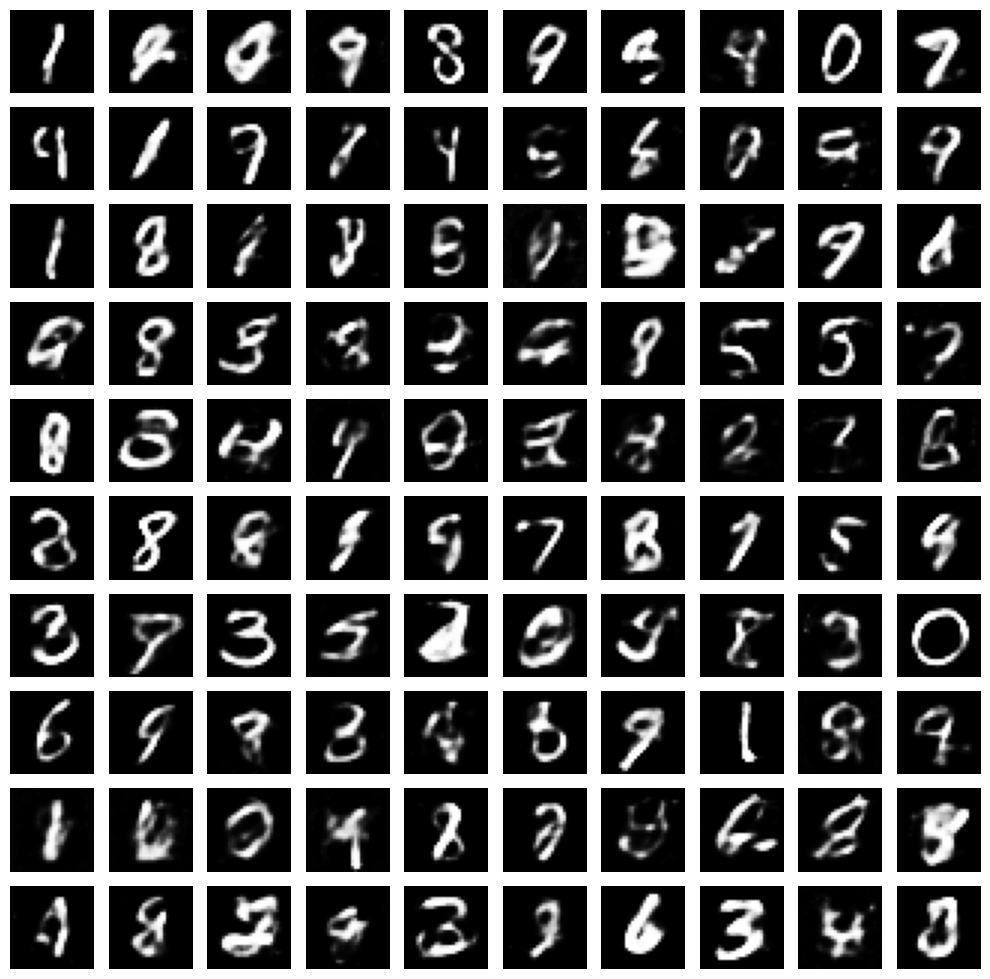

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming images is your numpy array
# Reshape it back to 28x28 images
images_reshaped = imgs.reshape(-1, 28, 28)

# Plot the first 50 images
fig, axes = plt.subplots(10, 10, figsize=(10,10))
axes = axes.ravel()

for i in np.arange(0, 100):
    axes[i].imshow(images_reshaped[i], cmap='gray')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

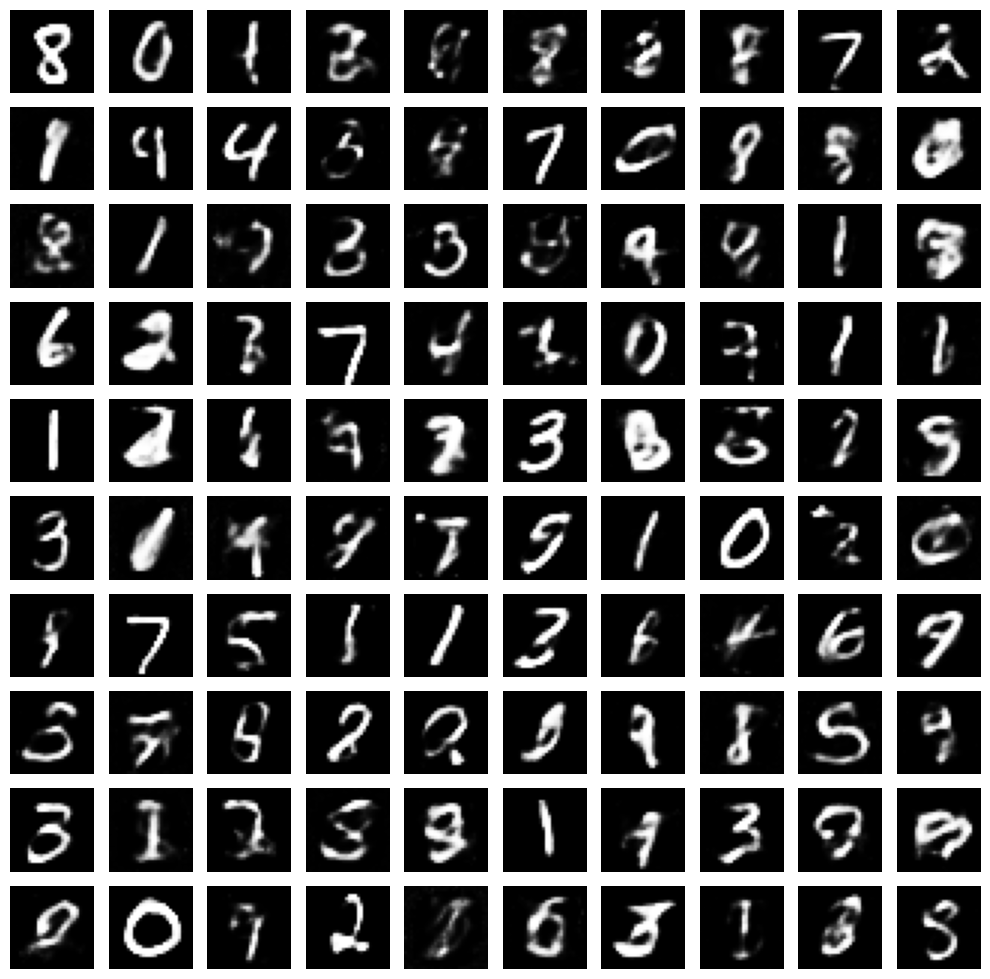

: 

In [55]:
# sort images by energy
sorted_indices = np.argsort(energies)
sorted_images = imgs[sorted_indices]

images_reshaped = sorted_images.reshape(-1, 28, 28)

# Plot the first 50 images
fig, axes = plt.subplots(10, 10, figsize=(10,10))
axes = axes.ravel()

# images with least energy
for i in np.arange(0, 50):
    axes[i].imshow(images_reshaped[i], cmap='gray')
    axes[i].axis('off')

# images with most energy
for i in np.arange(0, 50):
    axes[i+50].imshow(images_reshaped[-50 + i], cmap='gray')
    axes[i+50].axis('off')


plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()